In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/tmp/ipykernel_370553/121805284.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from sklearn.model_selection import train_test_split
from opensoundscape import BoxedAnnotations, CNN
import opensoundscape

In [3]:
n_samples_per_class = 5221
filename = 'Shallow_classifier_perch_resample_full'

In [4]:
metadata = pd.read_csv('./data/metadata.csv')
metadata.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Species,Conf,Call_type,Filename,SiteHab,RecordingSched,RecorderName,DP,SoundFile,SoundFile_path,Split,Raven_path
0,0,0.763354,3.078034,2854.369,5965.410,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
1,1,6.588949,9.475884,2571.297,5451.150,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
2,2,10.434780,12.523959,3085.557,5348.299,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
3,3,14.854197,15.436757,3085.557,5862.558,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
4,4,55.578030,59.479764,2621.359,5475.728,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...


In [5]:
val_metadata=metadata[metadata["Split"]=="validation"]
train_metadata=metadata[metadata["Split"]=="train"]
test_metadata=metadata[metadata["Split"]=="test"]

In [6]:
val_metadata=val_metadata.reset_index()
train_metadata=train_metadata.reset_index()
test_metadata=test_metadata.reset_index()

In [7]:
# assume we have a list of raven annotation files and corresponding audio files
# load the annotations into OpenSoundscape
raven_file_paths = val_metadata['Raven_path']
audio_file_paths = val_metadata['SoundFile_path']
val_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = train_metadata['Raven_path']
audio_file_paths = train_metadata['SoundFile_path']
train_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = test_metadata['Raven_path']
audio_file_paths = test_metadata['SoundFile_path']
test_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

In [8]:
# Create the table with a dataframe
conversion_table = pd.DataFrame(
    {'original':['Eulemur_albifrons', 'Eulemur_fulvus'],
     'new':['Eulemur_sp', 'Eulemur_sp']}
)

# Or create the table in its own spreadsheet
#conversion_table = pd.read_csv('my_conversion_filename_here.csv')

conversion_table

,original,new
0,Eulemur_albifrons,Eulemur_sp
1,Eulemur_fulvus,Eulemur_sp


In [ ]:
#correct annotations in each of the splits
val_annotations_corrected = val_annotations.convert_labels(conversion_table)
val_annotations_corrected.audio_files = val_annotations_corrected.df['audio_file'].values #workaround for issue #872
val_annotations_corrected.df.head()

train_annotations_corrected = train_annotations.convert_labels(conversion_table)
train_annotations_corrected.audio_files = train_annotations_corrected.df['audio_file'].values #workaround for issue #872
train_annotations_corrected.df.head()

test_annotations_corrected = test_annotations.convert_labels(conversion_table)
test_annotations_corrected.audio_files = test_annotations_corrected.df['audio_file'].values #workaround for issue #872
test_annotations_corrected.df.head()


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Delta Freq (Hz),Avg Power Density (dB FS/Hz),Channel,Conf,Selection,Call_type,View,Delta Time (s)
0,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Hypsipetes_madagascariensis,54.905264,56.190913,1968.454,5223.975,NaN,NaN,1,0.9,1,call,Spectrogram 1,NaN
1,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,4.943181,11.329778,659.794,5690.722,NaN,NaN,1,0.9,1,call,Spectrogram 1,NaN
2,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,13.011363,15.447871,551.700,5773.196,NaN,NaN,1,0.9,2,call,Spectrogram 1,NaN
3,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,17.215908,19.923388,494.845,5773.196,NaN,NaN,1,0.9,3,call,Spectrogram 1,NaN
4,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,24.282540,29.043458,742.268,6103.093,NaN,NaN,1,0.9,4,call,Spectrogram 1,NaN


In [10]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']

In [11]:
# create labels for fixed-duration (5 second) clips
val_labels = val_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

train_labels = train_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

test_labels = test_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

In [12]:
train_labels_resampled = opensoundscape.data_selection.resample(train_labels,n_samples_per_class = n_samples_per_class, downsample = False,upsample = True)

In [13]:
from bioacoustics_model_zoo import Perch

In [14]:
perch_model = Perch()

2025-01-22 23:14:51.417503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 23:14:51.417544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 23:14:51.418496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 23:14:51.423470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 23:14:53.111314: I exter

In [15]:
emb_train = perch_model.embed(train_labels_resampled, return_dfs=False, batch_size=128, num_workers=0)
emb_val = perch_model.embed(val_labels, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/775 [00:00<?, ?it/s]

2025-01-22 23:14:59.059612: I external/local_xla/xla/service/service.cc:168] XLA service 0x641a4d9fa160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 23:14:59.059659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-01-22 23:14:59.303005: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-22 23:14:59.311158: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-01-22 23:14:59.891075: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-22 23:15:02.930825: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,160,500,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,160,755

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-22 23:32:47.852594: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In [16]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']



In [17]:
perch_model.change_classes(class_list) # replace fc layer with 1-output layer
quick_fit(perch_model.network, emb_train, train_labels_resampled.values, emb_val, val_labels.values,steps=1000)

Epoch 100/1000, Loss: 0.18424038589000702, Val Loss: 0.16099761426448822
val AU ROC: 0.283
val MAP: 0.283


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 200/1000, Loss: 0.11800569295883179, Val Loss: 0.1117333248257637
val AU ROC: 0.442
val MAP: 0.442


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 300/1000, Loss: 0.08599314838647842, Val Loss: 0.09120684117078781
val AU ROC: 0.479
val MAP: 0.479


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 400/1000, Loss: 0.0674748346209526, Val Loss: 0.07945583760738373
val AU ROC: 0.490
val MAP: 0.490


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 500/1000, Loss: 0.05550675094127655, Val Loss: 0.07192137837409973
val AU ROC: 0.492
val MAP: 0.492


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 600/1000, Loss: 0.04713115468621254, Val Loss: 0.06673095375299454
val AU ROC: 0.493
val MAP: 0.493


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 700/1000, Loss: 0.0409211702644825, Val Loss: 0.06296616047620773
val AU ROC: 0.492
val MAP: 0.492


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 800/1000, Loss: 0.036117419600486755, Val Loss: 0.060130130499601364
val AU ROC: 0.490
val MAP: 0.490


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 900/1000, Loss: 0.03228289261460304, Val Loss: 0.05793129652738571
val AU ROC: 0.491
val MAP: 0.491


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 1000/1000, Loss: 0.029147757217288017, Val Loss: 0.05618828535079956
val AU ROC: 0.493
val MAP: 0.493
Training complete


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

In [18]:
val_labels

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                             False   
                                                   5.0        10.0                            False   
                                                   10.0       15.0                            False   
                                                   15.0       20.0                            False   
                                                   20.0       25.0                            False   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                             True   
                                                   40.0       45.0                             True   
                                                   45.0       50.0                             True   
                                                   50.0       55.0                             True   
                                                   55.0       60.0                             True   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                         False   
                                                   40.0       45.0                         False   
                                                   45.0       50.0                         False   
                                                   50.0       55.0                         False   
                                                   55.0       60.0                         False   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                  False   
                                                   5.0        10.0                 False   
                                                   10.0       15.0                 False   
                                                   15.0       20.0                 False   
                                                   20.0       25.0                 False   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                 False   
                                                   40.0       45.0                 False   
                                                   45.0       50.0                 False   
                                                   50.0       55.0                 False   
                                                   55.0       60.0                 False   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

In [19]:
# make predictions by passing the embeddings through the classifier
preds = perch_model.network(torch.tensor(emb_val).float()).detach().numpy()

preds = pd.DataFrame(preds,index=val_labels.index,columns=val_labels.columns)
preds

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          0.442242   
                                                   5.0        10.0                        -1.219409   
                                                   10.0       15.0                        -0.712239   
                                                   15.0       20.0                        -1.364011   
                                                   20.0       25.0                        -1.793821   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                        -2.360789   
                                                   40.0       45.0                        -2.429667   
                                                   45.0       50.0                        -2.700440   
                                                   50.0       55.0                        -3.310641   
                                                   55.0       60.0                        -1.454336   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                      -3.348387   
                                                   5.0        10.0                     -4.616866   
                                                   10.0       15.0                     -4.998057   
                                                   15.0       20.0                     -1.820592   
                                                   20.0       25.0                     -4.274250   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                     -4.085237   
                                                   40.0       45.0                     -4.516417   
                                                   45.0       50.0                     -2.753410   
                                                   50.0       55.0                     -4.469221   
                                                   55.0       60.0                     -3.144888   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0              -3.387710   
                                                   5.0        10.0             -2.736251   
                                                   10.0       15.0             -2.891055   
                                                   15.0       20.0             -3.308431   
                                                   20.0       25.0             -2.275124   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0             -4.229442   
                                                   40.0       45.0             -5.080958   
                                                   45.0       50.0             -4.416505   
                                                   50.0       55.0             -5.230480   
                                                   55.0       60.0             -4.832216   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py

array([0.91695192, 0.98892606, 0.98969883, 0.99245906, 0.98719423,
       0.99188978, 0.99894508, 0.9872442 , 0.99965753, 0.98997962,
       0.98603785,        nan,        nan, 0.81478969, 0.99751075,
       0.61862678, 0.94754434,        nan, 0.89694915])

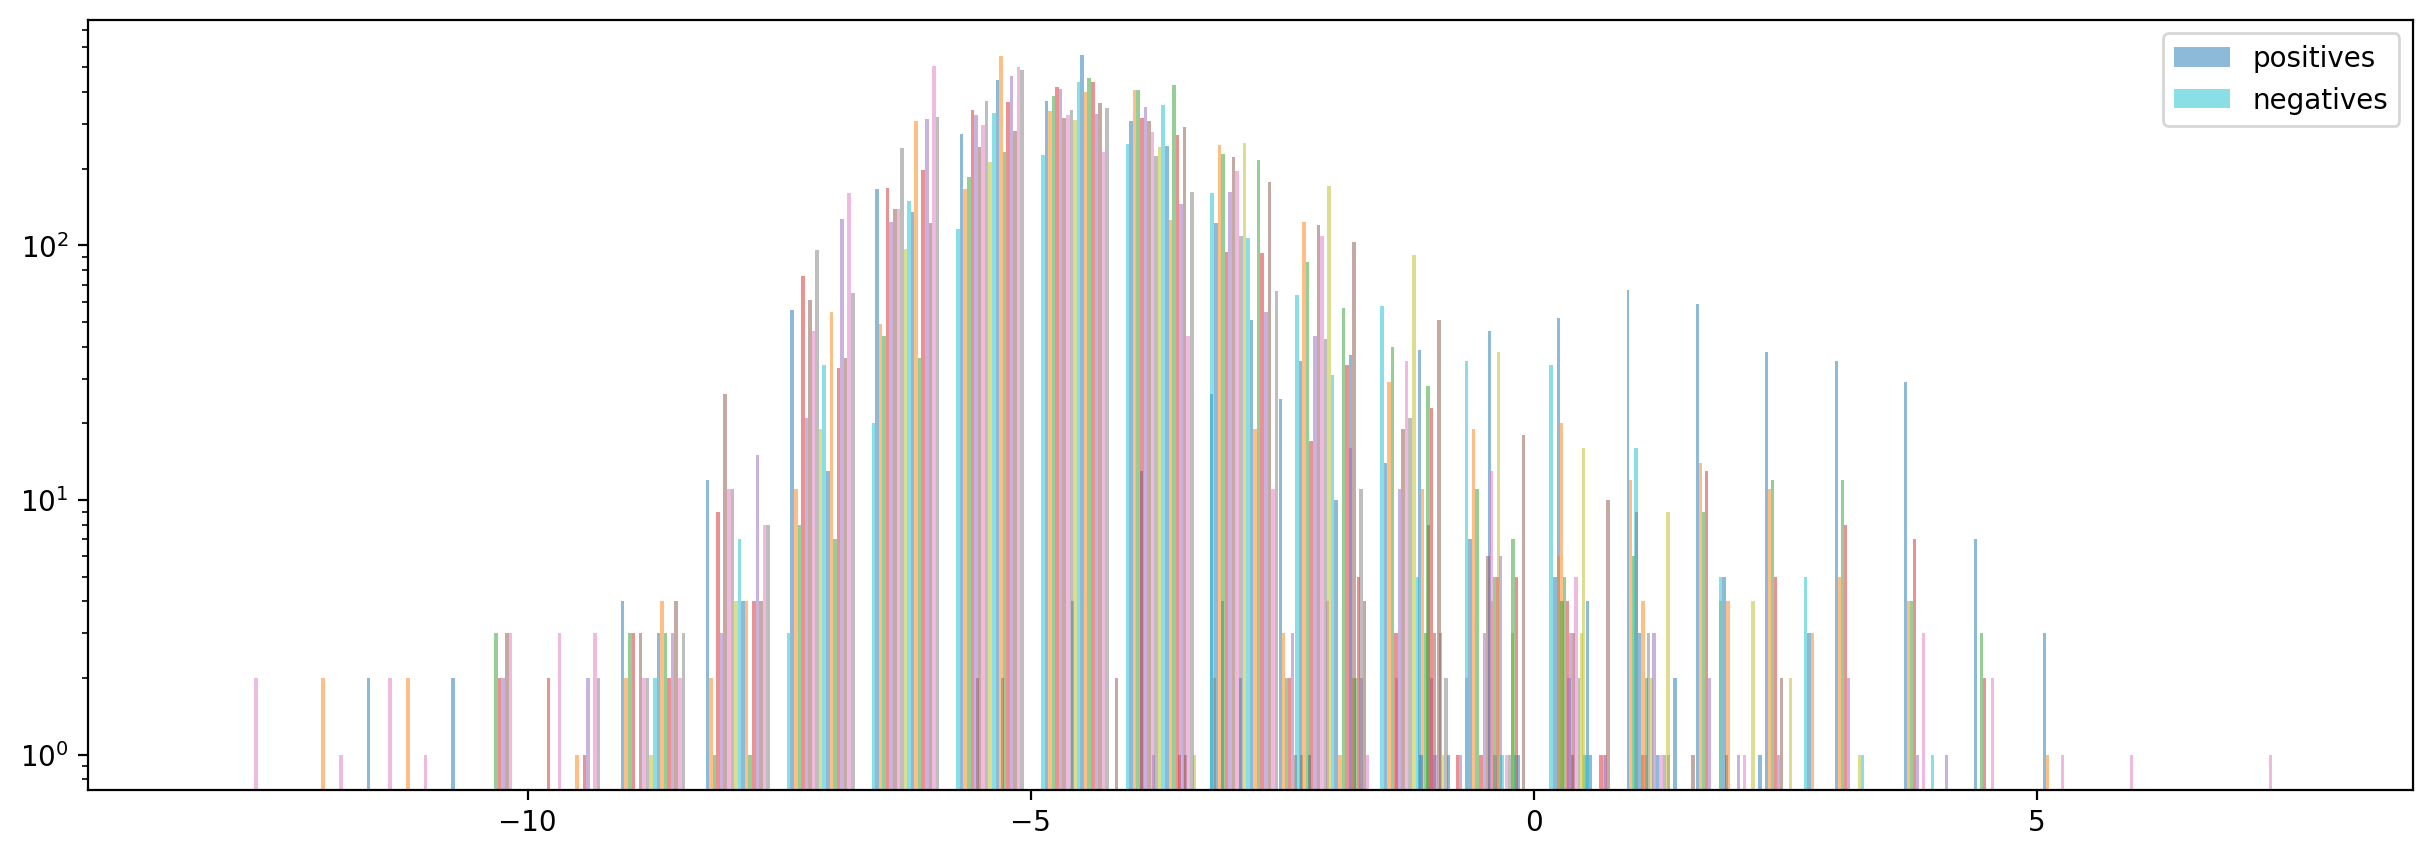

In [20]:

# plot histogram of scores for positive and negative clips
plt.hist(preds[val_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[val_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()
plt.semilogy()

# calculate the area under the ROC score
roc_auc_score(val_labels.values,preds,average=None)

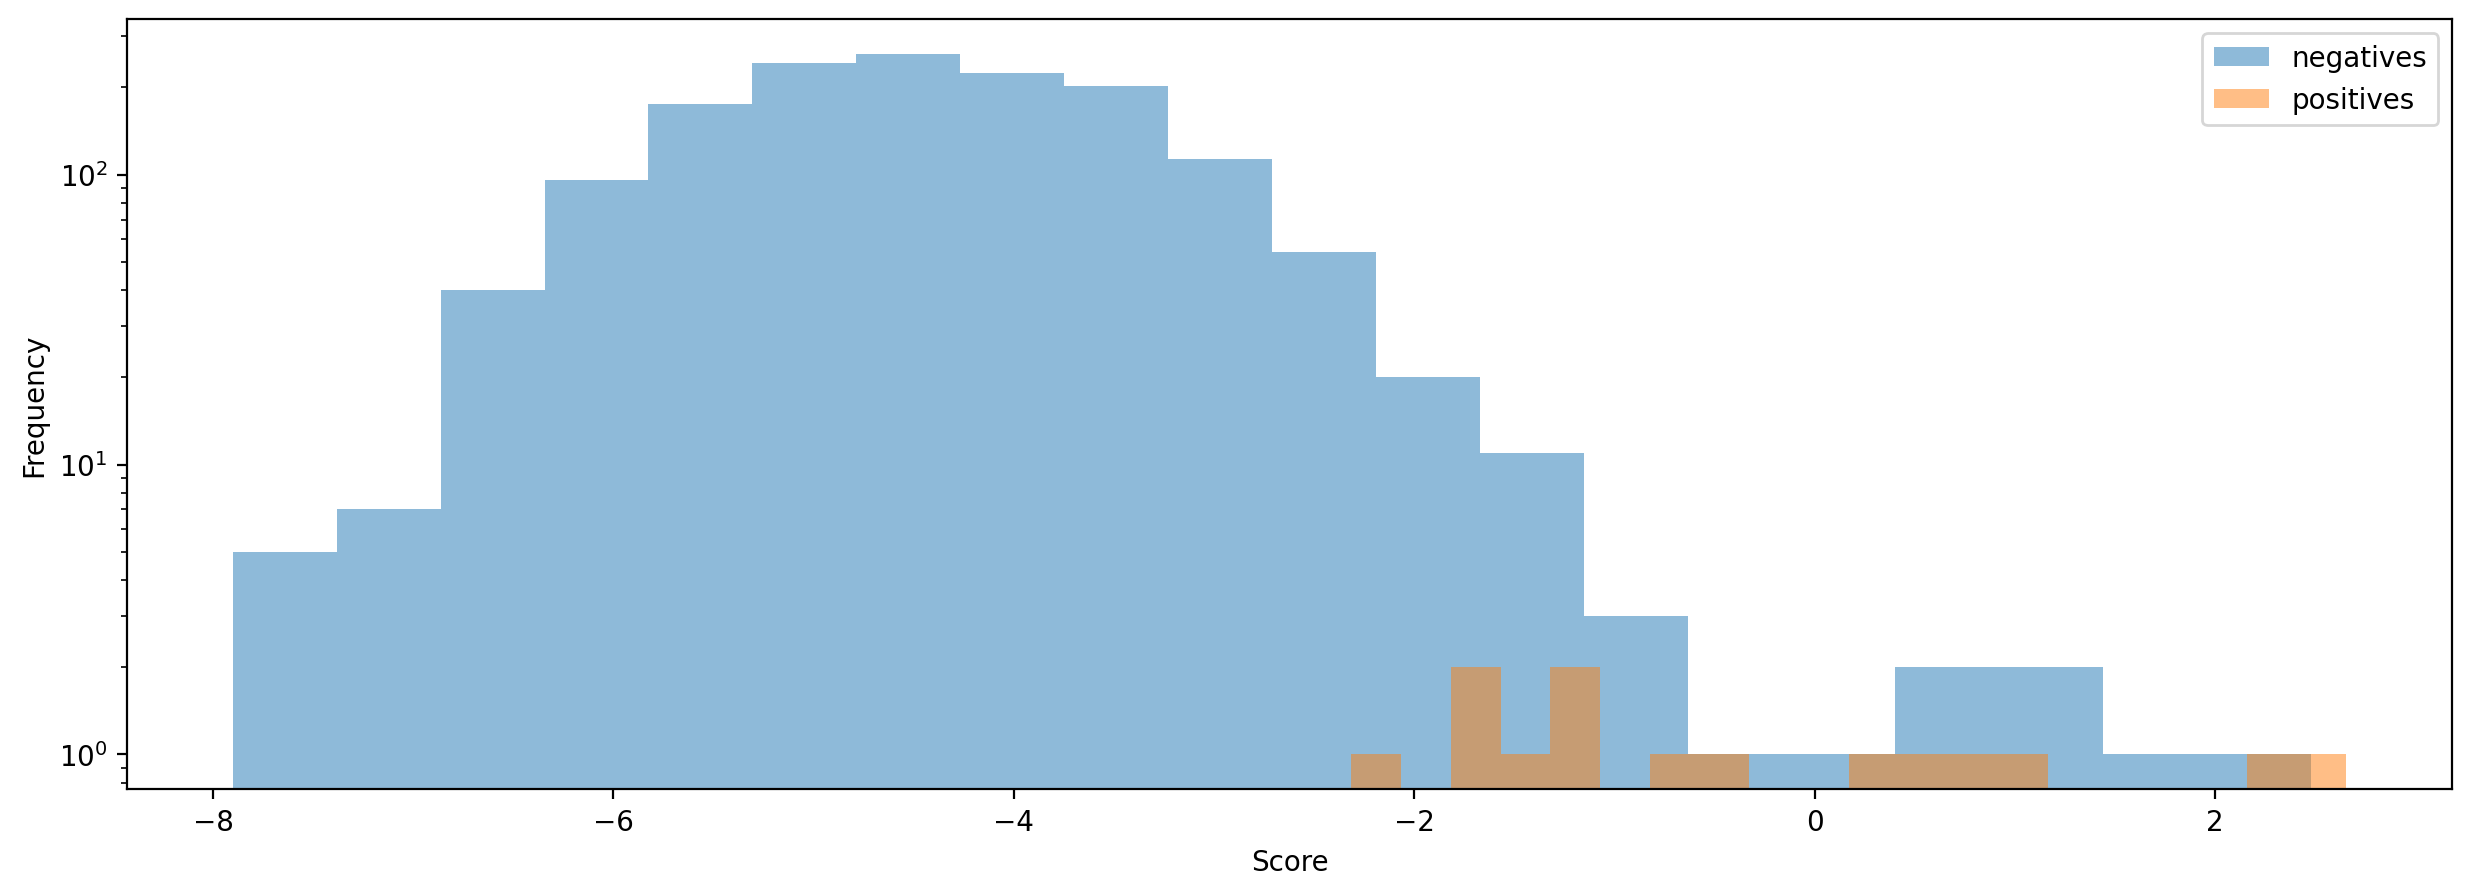

In [21]:
histspecies = 'Zosterops_maderaspatanus'
# Filter
df_Pos = preds[val_labels==True]
df_NOT = preds[val_labels==False]
# Plot histograms
plt.hist(df_NOT[histspecies],bins=20,alpha=0.5,label='negatives')
plt.hist(df_Pos[histspecies],bins=20,alpha=0.5,label='positives')
# Add a legend and labels
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.semilogy()
# Show the plot
plt.show()

In [22]:
avprecscore_auroc_by_sp = pd.DataFrame(columns=['species', 'avg_precision_score','auroc_score'])
for species in class_list:
    avgscore = sklearn.metrics.average_precision_score(val_labels [species],preds [species])
    auroc = sklearn.metrics.roc_auc_score(val_labels[species],preds [species])
    new_row = pd.DataFrame({'species': [species], 'avg_precision_score': [avgscore], 'auroc_score': [auroc]})
    avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)

avprecscore_auroc_by_sp

/tmp/ipykernel_370553/3174497413.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarni

,species,avg_precision_score,auroc_score
0,Hypsipetes_madagascariensis,0.846059,0.916952
1,Copsychus_albospecularis,0.795245,0.988926
2,Coracopsis_nigra,0.830705,0.989699
3,Dicrurus_forficatus,0.900632,0.992459
4,Coua_caerulea,0.801678,0.987194
5,Zosterops_maderaspatanus,0.492993,0.991890
6,Eurystomus_glaucurus,0.937863,0.998945
7,Agapornis_canus,0.512439,0.987244
8,Saxicola_torquatus,0.961838,0.999658
9,Cyanolanius_madagascarinus,0.553102,0.989980


In [23]:
avprecscore_auroc_by_sp.to_csv(f'/mnt/class_data/group1_bioacoustics/sheila/results/{filename}.csv')